In [1]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import h5py
from numpy.fft import fft2, ifft2, fftshift, ifftshift
import imageio.v2 as imageio
import random
import time


# Setup

In [2]:
# Size of the object
object_shape = (512, 512)

# Side length of the probe
n_probe = 128

# Probe shift for intensity measurement
shift = 64


## Realistic Synthetic Object and Probe

In [3]:
mat_data = scipy.io.loadmat('recon_zoneplate_Yi.mat')
obj = mat_data['obj']
orgn_probe = mat_data['probe']

pad_x = (object_shape[0] - obj.shape[0]) // 2
pad_y = (object_shape[1] - obj.shape[1]) // 2

# Pad the object to the desired shape
real_object = np.pad(obj, ((pad_x, pad_x), (pad_y, pad_y)), mode='edge')

ratio = orgn_probe.shape[0] // n_probe

real_probe = orgn_probe[::ratio,::ratio]

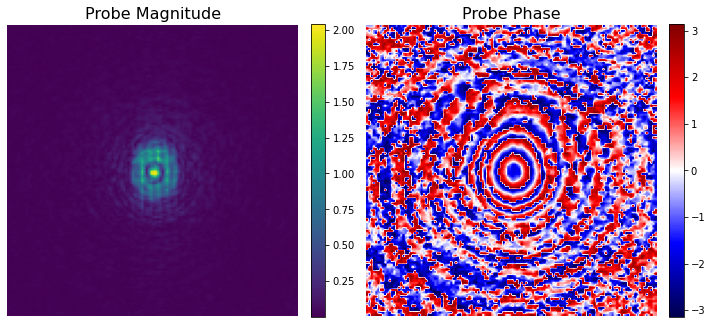

In [4]:
# Compute magnitude and phase
magnitude = np.abs(real_probe)
phase = np.angle(real_probe)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

ax = axes[0]
im0 = ax.imshow(magnitude, cmap='viridis')
ax.set_title('Probe Magnitude', fontsize = 16)
ax.axis('off')
plt.colorbar(im0, ax=ax, fraction=0.046, pad=0.04)

ax = axes[1]
im1 = ax.imshow(phase, cmap='seismic')
ax.set_title('Probe Phase', fontsize = 16)
ax.axis('off')
plt.colorbar(im1, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
#plt.savefig('probe_mag_phase.png', dpi=120, bbox_inches='tight')
plt.show()

In [5]:
magnitude = np.abs(real_object)
phase = np.angle(real_object)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

ax = axes[0]
im0 = ax.imshow(magnitude, cmap='viridis')
ax.set_title('Object Magnitude', fontsize = 16)
ax.axis('off')
plt.colorbar(im0, ax=ax, fraction=0.046, pad=0.04)

ax = axes[1]
im1 = ax.imshow(phase, cmap='viridis')
ax.set_title('Object Phase', fontsize = 16)
ax.axis('off')
plt.colorbar(im1, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
#plt.savefig('realistic_object.png', dpi=120, bbox_inches='tight')
plt.show()

## Test Synthetic Object 

In [6]:
# Load the images
baboon_image = imageio.imread('baboon.tiff')
# Convert the Baboon image to grayscale 
if baboon_image.ndim == 3:
    baboon_image = np.mean(baboon_image, axis=2)
    
cameraman_image = imageio.imread('cameraman.tif')
if cameraman_image.ndim == 3:
    cameraman_image = np.mean(cameraman_image, axis=2)

# Normalize the Baboon image to [0, 1] for magnitude
baboon_magnitude = baboon_image / np.max(baboon_image)

# Normalize the Cameraman image to [0, pi/2] for phase
cameraman_phase = (cameraman_image / np.max(cameraman_image)) * (np.pi / 2)

synthetic_object = baboon_magnitude * np.exp(1j * cameraman_phase)


In [7]:
magnitude = np.abs(synthetic_object)
phase = np.angle(synthetic_object)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

ax = axes[0]
im0 = ax.imshow(magnitude, cmap='viridis')
ax.set_title('Object Magnitude', fontsize = 16)
ax.axis('off')
plt.colorbar(im0, ax=ax, fraction=0.046, pad=0.04)

ax = axes[1]
im1 = ax.imshow(phase, cmap='viridis')
ax.set_title('Object Phase', fontsize = 16)
ax.axis('off')
plt.colorbar(im1, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
#plt.savefig('synthetic_object.png', dpi=120, bbox_inches='tight')
plt.show()


## Data Generation

In [8]:
def generate_intensity_measurements(z, Q, positions, noise_level):
    measurements = []
    for position in positions:
        x, y = position
        z_k = z[x:x+Q.shape[0], y:y+Q.shape[1]]
        exit_wave = Q * z_k
        d_k = np.abs(fft2(exit_wave))**2
        
        if noise_level > 0:
            # Scale the intensity to control noise level
            scaled_d_k = d_k / noise_level
            
            # Add Poisson noise
            noisy_scaled_d_k = np.random.poisson(scaled_d_k)
            # Scale back the noisy data to the original range
            d_k_noisy = noisy_scaled_d_k * noise_level
        else:
            # No noise added, return the original data
            d_k_noisy = d_k
        
        measurements.append(d_k_noisy)
    return np.array(measurements)


In [9]:
# Choose Object
probe = real_probe
ground_truth = synthetic_object

# Noise added to the measurement
noise_level = 0.05

# Define scanning positions
def positions(level):
    return [(x, y) for x in range(0, object_shape[0]//2**level - n_probe//2**level + 1, shift//2**level)
                    for y in range(0, object_shape[1]//2**level - n_probe//2**level + 1, shift//2**level)]

# Generate the data
data = generate_intensity_measurements(ground_truth, probe, positions(0), noise_level)


## Misfits

In [10]:
def feasibility_distance_misfit(z, Q, data, pos_array):
    m = data.shape[1]
    n = int(np.sqrt(z.size))
    N = data.shape[0]

    f   = 0
    g   = 0
    dfz = np.zeros(2 * n * n, dtype=float)

    z = z.reshape(n, n)
    Q = Q.reshape(m, m)

    for k in range(N):
        x, y = pos_array[k]
        z_k  = z[x:x+m, y:y+m]
        ew_k = Q * z_k

        # Fourier and inverse Fourier operations
        fft_ew_k = fft2(ew_k)
        rew_k    = ifft2(np.sqrt(data[k]) * np.exp(1j * np.angle(fft_ew_k)))
        res_k    = ew_k - rew_k  

        # Calculating the residual and the gradient
        f += 0.5 * np.linalg.norm(res_k.flatten(), 2)**2

        dfz_temp = np.conj(Q) * res_k
        g       += np.linalg.norm(dfz_temp.flatten(), 2) / N / m
        dfz_k    = np.zeros((n, n), dtype=complex)
        dfz_k[x:x+m, y:y+m] = dfz_temp
        
        dfz += dfz_k.flatten().view(float)

    return f, dfz, g

# Algorithms

In [11]:
def downsample(vh):
    if len(vh.shape) == 1:
        nh = int(np.sqrt(vh.shape[0]))
        vh = vh.reshape(nh, nh)
    nh = vh.shape[0] 
    nw = vh.shape[1] 
    vH = 0.25 * (
        vh[0:nh:2, 0:nw:2] +
        vh[0:nh:2, 1:nw:2] +
        vh[1:nh:2, 0:nw:2] +
        vh[1:nh:2, 1:nw:2]
    )
    return vH

def upsample(vH):
    if len(vH.shape) == 1:
        nH = int(np.sqrt(vH.shape[0]))
        vH = vH.reshape(nH, nH)
    vh = np.repeat(np.repeat(vH, 2, axis=0), 2, axis=1)
    return vh

def args_init(data):
    return np.zeros_like(data, dtype=float)

def REW(Q, z_k, d_k, args_pre):
    exit_wave = Q * z_k
    exit_wave_ft = fft2(exit_wave)
    mask = np.abs(exit_wave_ft) == 0
    args = np.angle(exit_wave_ft)
    args[mask] = args_pre[mask]
    rew = ifft2(np.sqrt(d_k) * np.exp(1j * args))
    return rew, args

def W_u(Q_sq, Q_H_sq):
    A = Q_H_sq 
    B = downsample(Q_sq)
    return np.divide(A, B, where=(B != 0), out=np.ones_like(A))

def W_z(Q_sq):
    A = Q_sq 
    B = upsample(downsample(Q_sq))
    return np.divide(A, B, where=(B != 0), out=np.zeros_like(A))

def W_rew(Q):
    Q_sq = np.abs(Q)**2
    A = Q_sq*upsample(downsample(Q))
    B = upsample(downsample(Q_sq))*Q
    return np.divide(A, B, where=(np.abs(B) != 0), out=np.zeros_like(A))

## rPIE

In [12]:
def rPIE_rand(z_init, Q, data, pos_array, num_iter, alpha=0.01, metric = False, gt = ground_truth, tol = 0.001):
    z_recon = z_init.copy()
    Q_abs   = np.abs(Q)
    Q_maxsq = np.max(Q_abs)**2
    Q_sq    = Q_abs**2
    step    = np.conj(Q) / ((1 - alpha)*Q_sq + alpha*Q_maxsq) 
    
    m    = Q.shape[0]
    res  = []
    err  = []
    arr  = list(range(len(pos_array))) 
    args = args_init(data)     
    
    if metric:
            f, df, g = feasibility_distance_misfit(z_recon, Q, data, pos_array)
            res.append(f)
            err.append(np.linalg.norm(np.abs(z_recon) - np.abs(gt)))
            print(f'Iteration: {0}, f: {f}, g: {g}, error: {err[-1]}')   
     
    for j in range(num_iter):
        random.shuffle(arr)
        
        for k in arr:
            x, y = pos_array[k]
            z_k  = z_recon[x:x+m, y:y+m]
            rew_k, args[k] = REW(Q, z_k, data[k], args[k])
            z_recon[x:x+m, y:y+m] += step * (rew_k - Q * z_k)    
            
        if metric:
            f, df, g = feasibility_distance_misfit(z_recon, Q, data, pos_array)
            res.append(f)
            err.append(np.linalg.norm(np.abs(z_recon) - np.abs(gt)))
            print(f'Iteration: {j+1}, f: {f}, g: {g}, error: {err[-1]}')   
            if g < tol:
                break
                
    return z_recon, np.array(res), np.array(err) 


## MAGPIE

In [13]:
def MAGPS(z_k, Q, rew, u):
    '''Recursively update z_k using probe Q and measurement rew_k.
    Base case: stop when downsampled Q has size 1x1.'''
    # Compute step for this level
    Q_sq = np.abs(Q) ** 2
    Q_sqmax = np.max(Q_sq)
    step = np.conj(Q) / (Q_sq + u)
    
    # Base case: if coarse region is 1x1, apply update and return
    if z_k.shape == (1, 1):
        return z_k + step * (rew - Q * z_k)
    
    # Compute coarse-level terms
    Q_H    = downsample(Q)
    Q_H_sq = np.abs(Q_H) ** 2
    z_H    = downsample(W_z(Q_sq) * z_k)
    rew_H  = downsample(W_rew(Q) * rew)
    u_H    = W_u(Q_sq, Q_H_sq) * downsample(u)  
    
    z_H_hat = MAGPS(z_H, Q_H, rew_H, u_H)

    # Propagate update up and apply fine-level correction
    z_k_tilde = z_k + upsample(z_H_hat - z_H)
    z_k_plus  = z_k_tilde + step * (rew - Q * z_k_tilde)
    return z_k_plus


def MAGPIE_recursion(z_init, Q, data, pos_array, num_iter, alpha=0.01, metric=False, gt=ground_truth, tol=1e-4):
    z       = z_init.copy()
    args    = args_init(data)
    res     = []
    err     = []
    h, w    = Q.shape
    Q_sq    = np.abs(Q) ** 2
    Q_sqmax = np.max(Q_sq)
    u       = alpha * (Q_sqmax - Q_sq)
    arr     = list(range(len(pos_array))) 
    
    if metric:
        f, _, g = feasibility_distance_misfit(z, Q, data, pos_array)
        res.append(f)
        err.append(np.linalg.norm(np.abs(z) - np.abs(gt)))
        print(f'Iteration: {0}, f: {f}, g: {g}, error: {err[-1]}')   
     
    for j in range(num_iter):
        random.shuffle(arr)
        
        for k in arr:
            x, y = pos_array[k]
            z_k  = z[x:x+h, y:y+w]
            rew, args[k] = REW(Q, z_k, data[k], args[k])

            z_k_plus = MAGPS(z_k, Q, rew, u)
            z[x:x+h, y:y+w] = z_k_plus
            
        if metric:
            f, _, g = feasibility_distance_misfit(z, Q, data, pos_array)
            res.append(f)
            err.append(np.linalg.norm(np.abs(z) - np.abs(gt)))
            print(f'Iteration: {j+1}, f: {f}, g: {g}, error: {err[-1]}')   
            if g < tol:
                break
            
    return z, np.array(res), np.array(err)


In [14]:
def MAGPIE_loops(z_init, Q, data, pos_array, 
                num_iter, alpha=0.01, metric=False, 
                gt=ground_truth, tol=1e-4, max_level=7):
    
    h, w   = Q.shape
    # Number of levels is max_level+1 (0 through max_level)
    levels = max_level + 1

    # 1) Build downsampled Qs
    Qs    = [None] * levels
    Qs[0] = Q.copy()
    for level in range(1, levels):
        Qs[level] = downsample(Qs[level-1])

    # 2) Precompute Q_sq and regularizaiton terms us
    Q_sq     = [np.abs(q)**2 for q in Qs]
    Q0_sqmax = np.max(Q_sq[0])

    us    = [None] * levels
    us[0] = alpha * (Q0_sqmax - Q_sq[0])
    for level in range(1, levels):
        us[level] = W_u(Q_sq[level-1], Q_sq[level]) * downsample(us[level-1])

    # 3) Compute step sizes
    steps = [
        np.conj(Qs[level]) / (Q_sq[level] + us[level])
        for level in range(levels)
    ]

    # 4) Precompute downsampling weights for z and rew
    Wz   = [W_z(Q_sq[level]) for level in range(levels-1)]
    Wrew = [W_rew(Qs[level]) for level in range(levels-1)]

    # 5) Initialize variables
    z    = z_init.copy()
    args = args_init(data)
    arr  = list(range(len(pos_array)))

    res = []
    err = []

    if metric:
        f, _, g = feasibility_distance_misfit(z, Q, data, pos_array)
        res.append(f)
        err.append(np.linalg.norm(np.abs(z) - np.abs(gt)))
        print(f'Iteration: {0}, f: {f}, g: {g}, error: {err[-1]}')   
     
    for j in range(num_iter):
        random.shuffle(arr)

        # Loop over scanning positions
        for k in arr:
            x, y = pos_array[k]
            z_k  = z[x:x+h, y:y+w]

            # Down-pass: build lists of z_patches and rew_values
            z_patches = [z_k]
            rew_vals = [None] * levels

            # Level 0 rew
            rew_vals[0], args[k] = REW(Q, z_k, data[k], args[k])

            # Levels 1…max_level: downsample
            for level in range(1, levels):
                z_down   = downsample(Wz[level-1] * z_patches[level-1])
                rew_down = downsample(Wrew[level-1] * rew_vals[level-1])
                z_patches.append(z_down)
                rew_vals[level] = rew_down

            # Up-pass: correction from coarsest level back to 0
            z_new  = z_patches[-1].copy()
            z_new += steps[-1] * (rew_vals[-1] - Qs[-1] * z_new)

            for level in range(levels-2, -1, -1):
                # upsample correction
                delta  = upsample(z_new - z_patches[level+1])
                z_new  = z_patches[level].copy() + delta
                z_new += steps[level] * (rew_vals[level] - Qs[level] * z_new)

            # Write updated patch back into z
            z[x:x+h, y:y+w] = z_new
            
        if metric:
            f, _, g = feasibility_distance_misfit(z, Q, data, pos_array)
            res.append(f)
            err.append(np.linalg.norm(np.abs(z) - np.abs(gt)))
            print(f'Iteration: {j+1}, f: {f}, g: {g}, error: {err[-1]}')   
            if g < tol:
                break

    return z, np.array(res), np.array(err)


## L-BFGS

In [15]:
def line_s(p, x, f, g, sfun, alpha=1.0, rho=0.8, c=1e-4, max_iter=20, eval_counters=None, eval_increment = 1):
    iter_count = 0
    while iter_count < max_iter:
        x_new = x + alpha * p
        f_new, g_new, g2 = sfun(x_new)
        if eval_counters is not None:
            eval_counters['func'] += eval_increment  
        if f_new <= f + c * alpha * np.dot(g, p):
            eval_counters['grad'] += eval_increment
            return x_new, f_new, g_new, g2, alpha
        alpha *= rho
        iter_count += 1    
    return x_new, f_new, g_new, g2, alpha

def lBFGS(x0, sfun, maxiter=100, m=5, gt=ground_truth, tol = 0.001):
    x = x0
    f, g, g2 = sfun(x)
    eval_counters = {'func': 1, 'grad': 1}
    eval_history = {'func': [1], 'grad': [1], 'f': [f], 'g2': [g2], 'error': [np.linalg.norm(np.abs(x.view(np.complex128).reshape(object_shape))-np.abs(gt))]}  
    
    n = len(x0)
    S = np.zeros((n, m))
    Y = np.zeros((n, m))
    rho_list = np.zeros(m)
    h0 = 1.0
    counter = 1
    
    for k in range(maxiter):
        if g2 < tol:
            if counter > 10:
                break
            else:
                counter += 1
            
        q = g
        alpha_list = np.zeros(m)
        
        for i in range(min(k, m)):
            j = (k - i - 1) % m
            rho_list[j] = 1.0 / np.dot(Y[:, j], S[:, j])
            alpha_list[j] = rho_list[j] * np.dot(S[:, j], q)
            q = q - alpha_list[j] * Y[:, j]
        
        r = h0 * q
        
        for i in range(min(k, m)):
            j = (k - min(k, m) + i) % m
            beta = rho_list[j] * np.dot(Y[:, j], r)
            r = r + S[:, j] * (alpha_list[j] - beta)
        
        p = -r
        
        x_new, f_new, g_new, g2, alpha = line_s(p, x, f, g, sfun, max_iter=100, eval_counters=eval_counters)
        
        s = x_new - x
        y = g_new - g
        
        if k < m:
            S[:, k] = s
            Y[:, k] = y
        else:
            S = np.roll(S, -1, axis=1)
            Y = np.roll(Y, -1, axis=1)
            S[:, -1] = s
            Y[:, -1] = y
        
        h0 = np.dot(s, y) / np.dot(y, y)
        
        x = x_new
        f = f_new
        g = g_new
        
        eval_history['func'].append(eval_counters['func'])
        eval_history['grad'].append(eval_counters['grad'])
        eval_history['f'].append(f)
        eval_history['g2'].append(g2)   
        eval_history['error'].append(np.linalg.norm(np.abs(x.view(np.complex128).reshape(object_shape))-np.abs(gt)))
        print(f"Iter {k+1}, f = {f}, g = {g2}, Func Evals = {eval_history['func'][-1]}, Error = {eval_history['error'][-1]}")

    return x, f, eval_history


# Numerical examples

In [16]:
z_initial = np.ones_like(ground_truth)
num_iterations = 1000
alpha_rpie = 0.01

s = time.time()
z_recon_rPIE, res_rPIE, errors_rPIE = rPIE_rand(z_initial, probe, data, positions(0), 
                                                num_iterations, alpha = alpha_rpie, 
                                                gt=ground_truth, metric = True, tol = 1e-4)
print(time.time()-s)

Iteration: 0, f: 1649.3242445996439, g: 0.05952197302585744, error: 242.3473661616201
Iteration: 1, f: 74.96198923159388, g: 0.0052177546584749575, error: 213.37183243954365
Iteration: 2, f: 38.822868894660914, g: 0.001915354631965236, error: 204.56299931077874
Iteration: 3, f: 28.708226669999434, g: 0.0011416411876615077, error: 198.54518272838155
Iteration: 4, f: 23.40419785583814, g: 0.0008245988759046073, error: 193.75323841262235
Iteration: 5, f: 19.967451967407705, g: 0.0006607271811584334, error: 189.69798820875758
Iteration: 6, f: 17.500371376104322, g: 0.000562678567632579, error: 186.1570129938061
Iteration: 7, f: 15.621450654395465, g: 0.0004961282439951918, error: 183.00193505297415
Iteration: 8, f: 14.129646223277263, g: 0.00044528664482174405, error: 180.14770170640256
Iteration: 9, f: 12.913515458982895, g: 0.0004125292137574391, error: 177.5378127524965
Iteration: 10, f: 11.898271027924807, g: 0.0003825709665194911, error: 175.13206085513966
Iteration: 11, f: 11.0363012

Iteration: 92, f: 1.641692779237045, g: 0.00014137351651402958, error: 115.5210203797722
Iteration: 93, f: 1.625091596923325, g: 0.00013950927778047398, error: 115.22526376311397
Iteration: 94, f: 1.608823809655126, g: 0.00013935196493311961, error: 114.93341783365136
Iteration: 95, f: 1.5931298936863203, g: 0.0001398414494850725, error: 114.6443219351496
Iteration: 96, f: 1.5772351679173031, g: 0.00013673938109614987, error: 114.35888724089466
Iteration: 97, f: 1.5621129190207523, g: 0.0001370713354082402, error: 114.07683700001206
Iteration: 98, f: 1.5472428789401338, g: 0.0001368225793477821, error: 113.79761852715019
Iteration: 99, f: 1.5326662448500321, g: 0.00013704615619336812, error: 113.52189545458039
Iteration: 100, f: 1.518507737119835, g: 0.00013669372148033762, error: 113.24892258185463
Iteration: 101, f: 1.5042872013404749, g: 0.00013571327517316914, error: 112.97904843664749
Iteration: 102, f: 1.4907063875901427, g: 0.00013547278790723545, error: 112.71179067504146
Itera

Iteration: 182, f: 0.882050207900061, g: 0.000109129973553621, error: 97.6656426681597
Iteration: 183, f: 0.8779302655398321, g: 0.00010956259535298378, error: 97.53033476819989
Iteration: 184, f: 0.8736190272404785, g: 0.00010826692438123572, error: 97.39631395655152
Iteration: 185, f: 0.8693246987115708, g: 0.0001065248065298577, error: 97.26275370204023
Iteration: 186, f: 0.8653056947701468, g: 0.00010761806502309208, error: 97.12999842338564
Iteration: 187, f: 0.8613115753785581, g: 0.00010786711844165736, error: 96.99795268695563
Iteration: 188, f: 0.8571802941405476, g: 0.0001056707538487331, error: 96.86729135015547
Iteration: 189, f: 0.853383789236837, g: 0.00010717282074522544, error: 96.73681610827042
Iteration: 190, f: 0.8493758429761996, g: 0.00010598715225609589, error: 96.60771041496731
Iteration: 191, f: 0.8456015657298069, g: 0.00010662894296191548, error: 96.47952589571581
Iteration: 192, f: 0.8418367623666715, g: 0.00010697721885430283, error: 96.35186149857353
Iterat

In [17]:
z_initial = np.ones_like(ground_truth)
num_iterations = 1000
alpha_rpie = 0.01
max_level = int(np.log2(probe.shape[0]))

s = time.time()
z_recon_MAGPIE, res_MAGPIE, errors_MAGPIE = MAGPIE_loops(z_initial, probe, data, positions(0), 
                                                   num_iterations, alpha = alpha_rpie, gt = ground_truth,
                                                   metric = True, tol = 1e-4, max_level = max_level)
print(time.time()-s)

Iteration: 0, f: 1649.3242445996439, g: 0.05952197302585744, error: 242.3473661616201
Iteration: 1, f: 24.502247406011353, g: 0.003620344885654249, error: 145.8638434604198
Iteration: 2, f: 11.923531832906056, g: 0.00133202046008741, error: 132.487613978444
Iteration: 3, f: 8.429520405680966, g: 0.0009345093993670569, error: 123.19281523352593
Iteration: 4, f: 6.540484361384593, g: 0.000710583829396424, error: 116.20488027079423
Iteration: 5, f: 5.381261576680515, g: 0.0005922796231925834, error: 110.65243304676561
Iteration: 6, f: 4.573040429654742, g: 0.0005061906173836023, error: 106.03174275628722
Iteration: 7, f: 3.983480891436581, g: 0.000457313724585, error: 102.08846344167749
Iteration: 8, f: 3.5459194982139968, g: 0.00043308993009469565, error: 98.65283474025215
Iteration: 9, f: 3.1890127891459334, g: 0.0003996439087553378, error: 95.61077993120526
Iteration: 10, f: 2.906496342163444, g: 0.00037129666393616713, error: 92.89671968453092
Iteration: 11, f: 2.672122598095471, g: 0

Iteration: 92, f: 0.4823523370693013, g: 0.00011395025642917038, error: 45.999624842336296
Iteration: 93, f: 0.47926924535624027, g: 0.00011602315786558955, error: 45.87074824624362
Iteration: 94, f: 0.47630430356011977, g: 0.00011591557364277233, error: 45.74269261369471
Iteration: 95, f: 0.4730206006368074, g: 0.00011378527461767383, error: 45.620638973021165
Iteration: 96, f: 0.4697513454247816, g: 0.00011071912670782444, error: 45.50083654698464
Iteration: 97, f: 0.4668431552030919, g: 0.00010894344080335392, error: 45.38085535371025
Iteration: 98, f: 0.46434091478032863, g: 0.00011225454888904553, error: 45.26292967555291
Iteration: 99, f: 0.46104165161168864, g: 0.00010928571188779255, error: 45.150408472027735
Iteration: 100, f: 0.45867892835052343, g: 0.00011133096025241558, error: 45.03783465808203
Iteration: 101, f: 0.4556960780523249, g: 0.00010826242978391687, error: 44.92815917614217
Iteration: 102, f: 0.4532679026446662, g: 0.00011029099014104887, error: 44.81984641484971

In [18]:
#z_initial = np.ones_like(ground_truth)
#num_iterations = 1000
#alpha_rpie = 0.01
#
#s = time.time()
#z_recon_MAGPIE, res_MAGPIE, errors_MAGPIE = MAGPIE_recursion(z_initial, probe, data, positions(0), 
#                                                   num_iterations, alpha = alpha_rpie, gt=ground_truth,
#                                                   metric = True, tol = 1e-4)
#print(time.time()-s)

In [19]:
def sfun(z):
    return feasibility_distance_misfit(z.view(np.complex128), probe, np.array(data), positions(0))

s = time.time()
z_initial = np.ones_like(ground_truth).flatten().view(float)
zstar, error_f_LBFGS, eval_history_LBFGS = lBFGS(z_initial, sfun, maxiter=1000, m=5, gt=ground_truth, tol = 1e-4)
print(time.time()-s)

Iter 1, f = 783.4330412208628, g = 0.04575912739497599, Func Evals = 2, Error = 234.4993467488465
Iter 2, f = 289.93541653948097, g = 0.01626250515877799, Func Evals = 3, Error = 232.7647606080748
Iter 3, f = 187.50113104119194, g = 0.009016023709657593, Func Evals = 4, Error = 231.4532837658482
Iter 4, f = 136.6488840551112, g = 0.006954852709341901, Func Evals = 5, Error = 229.8515858111014
Iter 5, f = 100.0346112882386, g = 0.006071000443476109, Func Evals = 6, Error = 227.3649083741283
Iter 6, f = 84.31482289779733, g = 0.004926185771687816, Func Evals = 7, Error = 225.57569935059246
Iter 7, f = 75.5708668414066, g = 0.0029960811125426417, Func Evals = 8, Error = 224.88672176431115
Iter 8, f = 65.50983155117636, g = 0.0026381521188069664, Func Evals = 9, Error = 222.9974736357436
Iter 9, f = 58.419497664326414, g = 0.0028289504779516303, Func Evals = 10, Error = 221.01745450849845
Iter 10, f = 51.76774488454657, g = 0.0026896591476634163, Func Evals = 11, Error = 218.6688174923714


Iter 81, f = 3.147437702077219, g = 0.0002442928773856555, Func Evals = 84, Error = 133.24838508878588
Iter 82, f = 3.109970521547787, g = 0.00022080489564954895, Func Evals = 85, Error = 133.15824659805372
Iter 83, f = 3.0326808937399665, g = 0.0002536849489328902, Func Evals = 86, Error = 132.51158302976492
Iter 84, f = 2.9938983211278325, g = 0.0003509356601453373, Func Evals = 87, Error = 131.63943454009055
Iter 85, f = 2.921909375125146, g = 0.0001827733534776748, Func Evals = 88, Error = 131.54445550885703
Iter 86, f = 2.8961337285742452, g = 0.00017813360684362255, Func Evals = 89, Error = 131.29444039436348
Iter 87, f = 2.840420540921072, g = 0.00019069240144902415, Func Evals = 90, Error = 130.61942480513852
Iter 88, f = 2.7940283263289363, g = 0.0005208009914033282, Func Evals = 91, Error = 129.42360326865952
Iter 89, f = 2.7062690619645684, g = 0.0001931213651549293, Func Evals = 92, Error = 129.15818203071652
Iter 90, f = 2.6827743417427703, g = 0.00016685291810292284, Func

Iter 159, f = 1.1756274890499419, g = 8.709753100756617e-05, Func Evals = 165, Error = 103.0335746416956
Iter 160, f = 1.1624639793495608, g = 0.00012855567315507666, Func Evals = 166, Error = 102.39573683976045
Iter 161, f = 1.1533801686720515, g = 9.45338236134374e-05, Func Evals = 167, Error = 102.05704477178901
53.25059914588928


In [20]:
res_f_LBFGS = eval_history_LBFGS['f']
errors_LBFGS = eval_history_LBFGS['error']

In [21]:
# Create a figure with 2 rows and 1 column of subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# --- Plot on the top subplot (Residuals) ---
ax1.plot(np.arange(1, len(res_f_LBFGS)+1), res_f_LBFGS, label='LBFGS', linestyle='-', marker='o', linewidth=1, markersize=2)
ax1.plot(np.arange(1, len(res_rPIE)+1), res_rPIE, label='rPIE', linestyle='-', marker='o', linewidth=1, markersize=2)
ax1.plot(np.arange(1, len(res_MAGPIE)+1), res_MAGPIE, label='MAGPIE', linestyle='-', marker='o', linewidth=1, markersize=2)
#ax1.set_xlabel('Iteration', fontsize=18)
ax1.set_ylabel('Residual', fontsize=14)
ax1.set_title('Log-Log Residual Comparison', fontsize=14)
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.legend()
ax1.grid(True, which="both", ls="--")

# --- Plot on the bottom subplot (Errors) ---
ax2.plot(np.arange(1, len(errors_LBFGS)+1), errors_LBFGS, label='LBFGS', linestyle='-', marker='o', linewidth=1, markersize=2)
ax2.plot(np.arange(1, len(errors_rPIE)+1), errors_rPIE, label='rPIE', linestyle='-', marker='o', linewidth=1, markersize=2)
ax2.plot(np.arange(1, len(errors_MAGPIE)+1), errors_MAGPIE, label='MAGPIE', linestyle='-', marker='o', linewidth=1, markersize=2)
ax2.set_xlabel('Iteration', fontsize=14)
ax2.set_ylabel('Error', fontsize=14)
ax2.set_title('Log-Log Error Comparison', fontsize=14)
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.legend()
ax2.grid(True, which="both", ls="--")
#plt.savefig('metric.png', dpi=200, bbox_inches='tight')

plt.tight_layout()
plt.show()



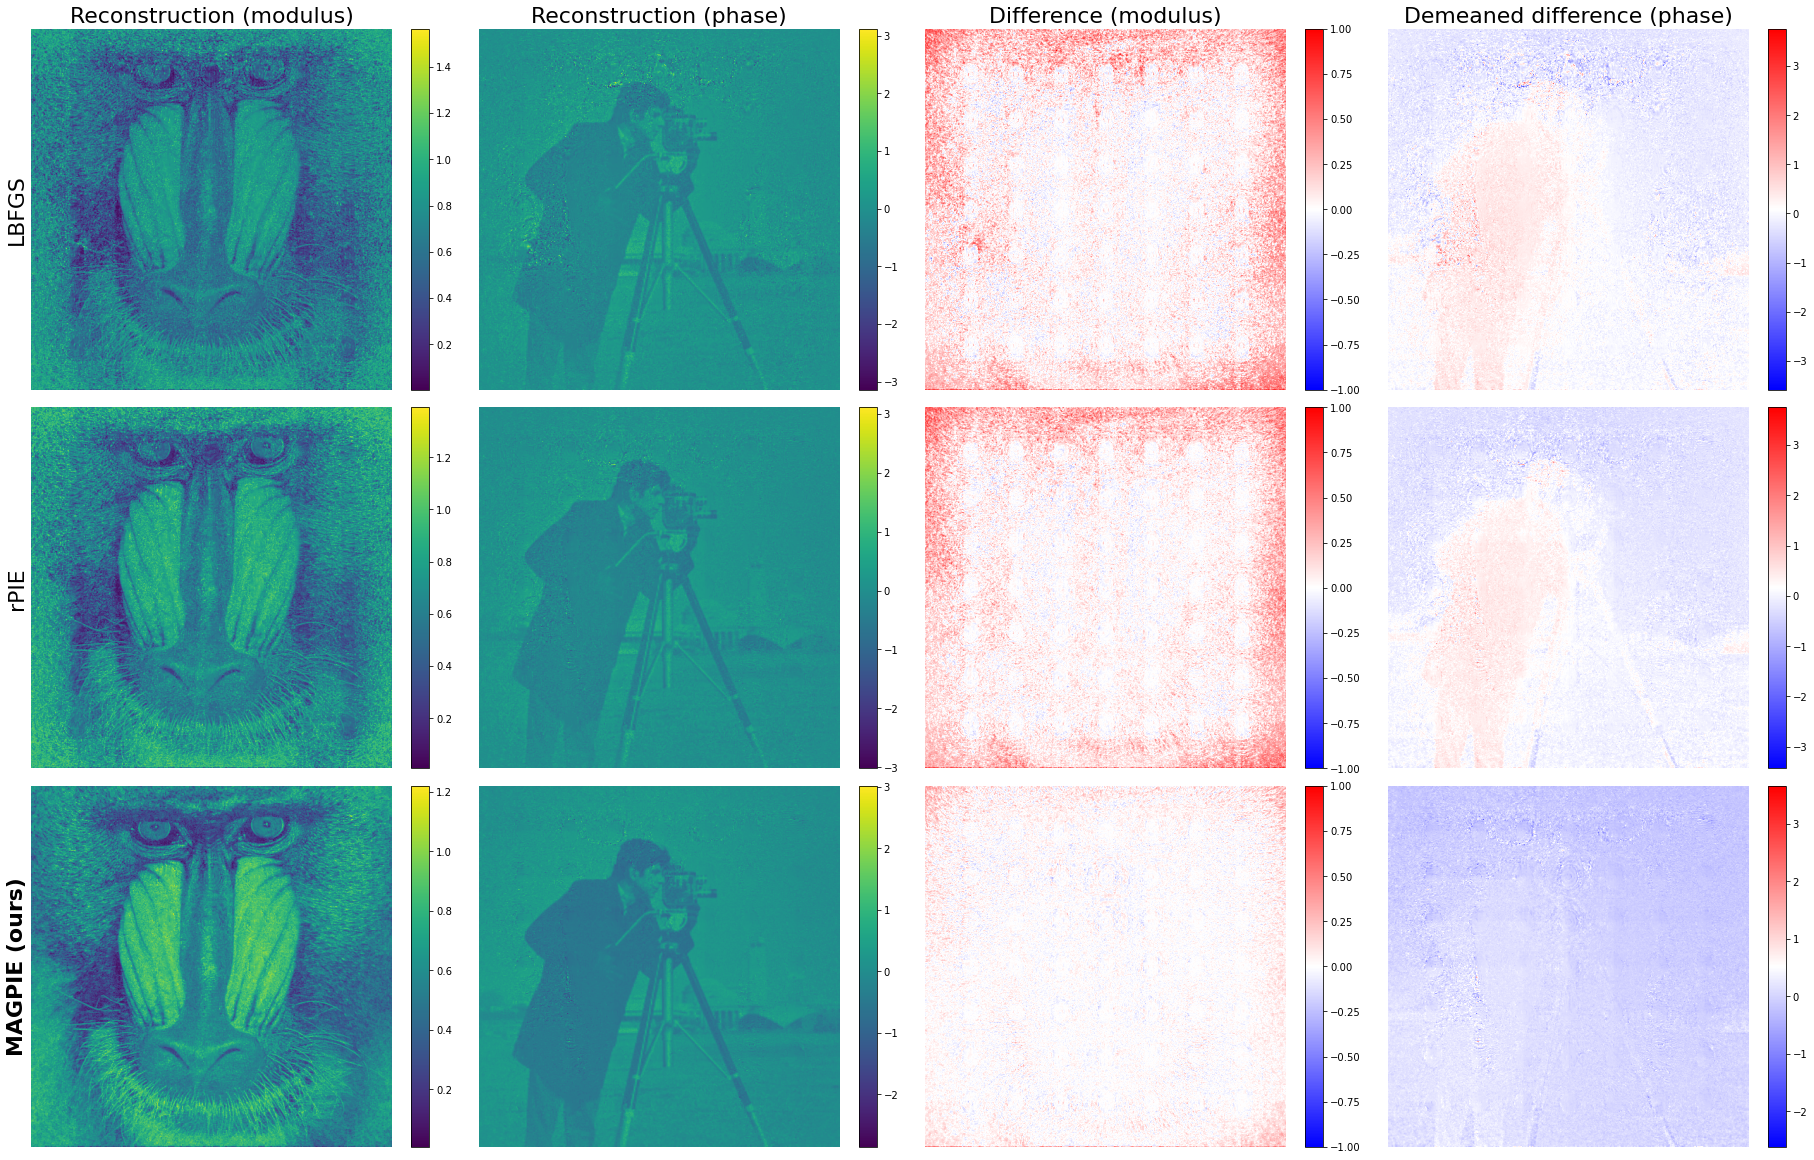

In [22]:
size = object_shape
rPIE_image = z_recon_rPIE
MAGPIE_image = z_recon_MAGPIE
LBFGS_image = zstar.view(np.complex128).reshape(object_shape)
ground_truth = ground_truth

intensity_ground_truth = np.abs(ground_truth)
phase_ground_truth = np.angle(ground_truth)

def calculate_difference(image, ground_truth):
    intensity_diff = np.abs(image) - intensity_ground_truth
    phase_diff = np.angle(image) - phase_ground_truth - np.mean(np.angle(image) - phase_ground_truth)
    return intensity_diff, phase_diff

intensity_LBFGS, phase_LBFGS = np.abs(LBFGS_image), np.angle(LBFGS_image)
intensity_rPIE, phase_rPIE = np.abs(rPIE_image), np.angle(rPIE_image)
intensity_MAGPIE, phase_MAGPIE = np.abs(MAGPIE_image), np.angle(MAGPIE_image)

# Calculate differences
intensity_diff_LBFGS, phase_diff_LBFGS = calculate_difference(LBFGS_image, ground_truth)
intensity_diff_rPIE, phase_diff_rPIE = calculate_difference(rPIE_image, ground_truth)
intensity_diff_MAGPIE, phase_diff_MAGPIE = calculate_difference(MAGPIE_image, ground_truth)

# Updated column titles and row labels
column_titles = [
    "Reconstruction (modulus)", 
    "Reconstruction (phase)", 
    "Difference (modulus)", 
    "Demeaned difference (phase)"
]
row_labels = ["LBFGS", "rPIE", "MAGPIE (ours)"]

# Prepare data for plotting: each tuple contains (intensity, phase, intensity_diff, phase_diff)
image_data = [
    (intensity_LBFGS, phase_LBFGS, intensity_diff_LBFGS, phase_diff_LBFGS),
    (intensity_rPIE, phase_rPIE, intensity_diff_rPIE, phase_diff_rPIE),
    (intensity_MAGPIE, phase_MAGPIE, intensity_diff_MAGPIE, phase_diff_MAGPIE),
]

# Create a new figure using subplots 
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(25, 16), constrained_layout=True)

# Set column titles on the first row.
for j, title in enumerate(column_titles):
    axes[0, j].set_title(title, fontsize=22)

# Loop over each row of image data.
for i, (intensity, phase, intensity_diff, phase_diff) in enumerate(image_data):
    # Set the row label for the first column.
    if i == 2:
        axes[i, 0].set_ylabel(row_labels[i], fontsize=22, fontweight='bold')
    else:
        axes[i, 0].set_ylabel(row_labels[i], fontsize=22)

    # Remove spines and ticks for clarity.
    for j in range(4):
        ax = axes[i, j]
        for spine in ax.spines.values():
            spine.set_visible(False)
        ax.set_xticks([])
        ax.set_yticks([])

    # Plot the intensity image.
    im0 = axes[i, 0].imshow(intensity, cmap='viridis')
    fig.colorbar(im0, ax=axes[i, 0])

    # Plot the phase image.
    im1 = axes[i, 1].imshow(phase, cmap='viridis')
    fig.colorbar(im1, ax=axes[i, 1])
    
    # Plot the intensity difference image with symmetric scaling.
    max_intensity_diff = np.max(np.abs(intensity_diff))
    im2 = axes[i, 2].imshow(intensity_diff, cmap='bwr', vmin=-1, vmax=1)
    fig.colorbar(im2, ax=axes[i, 2])

    # Plot the phase difference image with symmetric scaling.
    max_phase_diff = np.max(np.abs(phase_diff))
    im3 = axes[i, 3].imshow(phase_diff, cmap='bwr')
    fig.colorbar(im3, ax=axes[i, 3])

#plt.savefig('reconstruction.png', dpi=60, bbox_inches='tight')
plt.show()